In [231]:
import numpy as np
import pandas as pd
import itertools
from progressbar import ProgressBar
import matplotlib.pyplot as plt


# Summary:

In this study I will analyze a "pokemon food chain" network based on their types and stats.  Consider pokemon as nodes.  A directed edge is formed from pokemon B to A if pokemon A's attacks are more effective than normal against pokemone B.

The effectiveness of attack is measured by the type chart and a pokemon's stats, which is formed by 3 categories: type advantage, regular attack advantage and special attack advantage.  
1. Since pokemons often have two types, I take the product of the effectiveness.  The offense is marked to have an advantage if the product is grater than 1.
2. Offense is marked to have a regular attack advantage over the defense if its attack stats are higher than the opponent's defense stats.
3. Offense is marked to have a special attack advantage over the defense if its special attack stats are higher than the opponent's special defense stats.

If the offense has an advantage in at least two out of the 3 categories, I add an edge pointing the defense to offense. More sophisticated metrics can be used to measure the matchup, but for the purpose of this analysis this will suffice.  As Ash Ketchum famously says: The best defense is a good offense! Based on this graph, I will use ranking methods to determine the pokemons with the best matchup advantage.

Intuitively, pageRank should indicate the pokemon with the strongest matchup advantage since the strongest pokemon would have the most nodes pointed to it.  Since the graph is densely connected, I expect the result to not be too intersting.  I will also use the HITS algorithm, as the ranking of hubs should give more interesting results that might pick out medium strength pokemon that only have disadvantage against strong pokemon

In [46]:
type_chart = pd.read_csv("hw2/type-chart.csv")
pokemons = pd.read_csv("hw2/pokemon.csv")

In [59]:
#converting types to lower cases
def l_case(x): 
    try:
        y = x.lower()
    except:
        y = "None"
    return(y)

pokemons["type1"] = pokemons["type1"].apply(l_case)
pokemons["type2"] = pokemons["type2"].apply(l_case)
type_chart["defense-type2"] = type_chart["defense-type2"].apply(l_case)
type_chart["None"]=1.0

# Data Examples

In [133]:
pokemons.head()

,id,ndex,species,forme,type1,type2,ability1,ability2,abilityH,hp,...,weight,height,dex1,dex2,class,percent-male,percent-female,pre-evolution,egg-group1,egg-group2
0,1,1,Bulbasaur,Bulbasaur,grass,poison,Overgrow,NaN,Chlorophyll,45,...,15.2 lbs.,"2'04""",NaN,NaN,Seed Pokémon,0.875,0.125,NaN,Monster,Grass
1,2,2,Ivysaur,Ivysaur,grass,poison,Overgrow,NaN,Chlorophyll,60,...,28.7 lbs.,"3'03""",NaN,NaN,Seed Pokémon,0.875,0.125,Bulbasaur,Monster,Grass
2,3,3,Venusaur,Venusaur,grass,poison,Overgrow,NaN,Chlorophyll,80,...,220.5 lbs.,"6'07""",NaN,NaN,Seed Pokémon,0.875,0.125,Ivysaur,Monster,Grass
3,4,4,Charmander,Charmander,fire,None,Blaze,NaN,Solar Power,39,...,18.7 lbs.,"2'00""",NaN,NaN,Lizard Pokémon,0.875,0.125,NaN,Monster,Dragon
4,5,5,Charmeleon,Charmeleon,fire,None,Blaze,NaN,Solar Power,58,...,41.9 lbs.,"3'07""",NaN,NaN,Flame Pokémon,0.875,0.125,Charmander,Monster,Dragon


In [134]:
type_chart.head()

,defense-type1,defense-type2,normal,fire,water,electric,grass,ice,fighting,poison,...,flying,psychic,bug,rock,ghost,dragon,dark,steel,fairy,None
0,normal,None,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,normal,fire,1.0,0.5,2.0,1.0,0.5,0.5,2.0,1.0,...,1.0,1.0,0.5,2.0,0.0,1.0,1.0,0.5,0.5,1.0
2,normal,water,1.0,0.5,0.5,2.0,2.0,0.5,2.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.5,1.0,1.0
3,normal,electric,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.0,...,0.5,1.0,1.0,1.0,0.0,1.0,1.0,0.5,1.0,1.0
4,normal,grass,1.0,2.0,0.5,0.5,0.5,2.0,2.0,2.0,...,2.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


There are over 1060 pokemons in this dataset, which corresponds to 562330 matchups.  However, since I don't really care for pokemons past generation 4, I will only be constructing the graph for the first 493 pokemons, which corresponds to 12127 matchups.

In [140]:
pokemons = pokemons.iloc[:493]

In [383]:
matchups = list(itertools.permutations(pokemons.index.values, 2))
len(matchups)/2

121278.0

In [176]:
def beats(offense, defense):
    o_ind = offense["id"]
    d_ind = defense["id"]

    d_type = type_chart[type_chart["defense-type1"]==defense["type1"]][type_chart["defense-type2"]==defense["type2"]]
    attack_effect = d_type[offense[["type1", "type2"]]]
    type_effect = np.prod(d_type[offense[["type1", "type2"]]].values) > 1
    attack_effect = defense["defense"]<offense["attack"]
    sattack_effect = defense["spdefense"]<offense["spattack"]

    overall = np.mean([type_effect, attack_effect, sattack_effect])
    if(overall > 0.5):
        return(1)
    else:
        return(0)
    
pbar = ProgressBar()

n = len(pokemons)
pokemon_network = np.zeros((n,n))
for i in pbar(range(n)):
    for j in range(n):
        offense = pokemons.iloc[i]
        defense = pokemons.iloc[j]

        pokemon_network[i,j] = beats(offense, defense)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
100% |########################################################################|


In [508]:
# np.savetxt("pokenet.csv", pokemon_network, delimiter=",")
data = pd.read_csv("pokenet.csv",header=None)

In [509]:
names = pokemons["species"]
data.columns = names.values
data["pokemon"] = names.values
data.index = data["pokemon"]
del data["pokemon"] 

In [510]:
names[np.argsort(np.sum(data.values, axis=1))][-10:]

447      Lucario
256     Blaziken
249        Ho-Oh
331     Cacturne
372    Salamence
481        Azelf
482       Dialga
483       Palkia
385       Deoxys
383     Rayquaza
Name: species, dtype: object

# Sample Network of first 20 pokemons

In [420]:
sample_set = data[names[:20]].loc[names[:20]]
flattened_set = sample_set.unstack(level=0).reset_index()
flattened_set.columns = ["Offense", "Defense", "value"]

edges = flattened_set[flattened_set["value"]==1][["Offense","Defense"]]

In [447]:
import networkx as nx
G = nx.DiGraph()
for node in names[:20]:
    G.add_node(node)
for edge in edges.values:
    G.add_edge(*tuple(edge))
    
pos = nx.layout.circular_layout(G)
node_sizes = 10+50*np.sum(sample_set.values, axis=1)

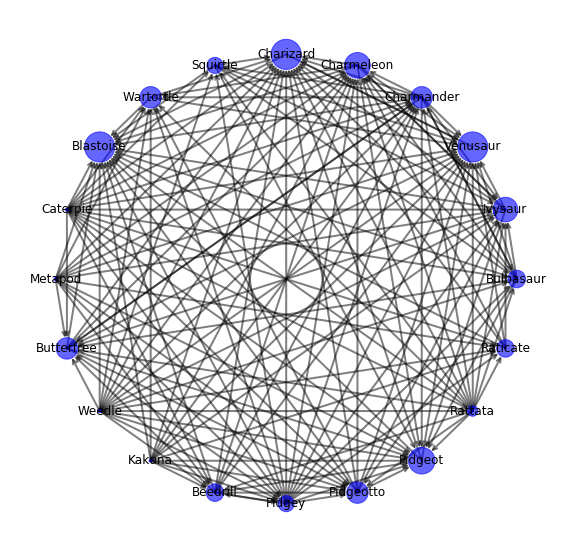

In [448]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue',alpha=0.6)
nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10,edge_cmap=plt.cm.Blues, width=2, alpha=0.5)
nx.draw_networkx_labels(G, pos)

plt.axis('off')
plt.show()

The Network is pretty dense so pageRank should converge quickly.

In [438]:
#set diagonal to 0
np.fill_diagonal(pokemon_network, 0)

#normalize column 
P = np.zeros((n,n))
for k in range(n):
    if(sum(pokemon_network[:,k]) > 0):
        P[:,k] = pokemon_network[:,k]/sum(pokemon_network[:,k])
    
#uniform teleportation
v = np.ones(n)/n
alpha=0.9

delta = []

x = np.ones(n)/n
iters = 10
for i in range(iters):
    x_new = alpha*(P@x)+(1-alpha)*v
    x_new = x_new/sum(x_new)
    delta.append(np.linalg.norm(x-x_new))
    x = x_new

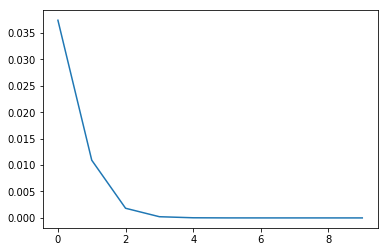

In [439]:
plt.plot(np.arange(iters), delta)

In [442]:
names[x.argsort()[-10:]]

249        Ho-Oh
149       Mewtwo
256     Blaziken
247    Tyranitar
372    Salamence
483       Palkia
482       Dialga
481        Azelf
383     Rayquaza
385       Deoxys
Name: species, dtype: object

Shocking Results

# HITS algorithm implementation.

In [458]:
a = np.ones(n)/n

iters = 10

A = pokemon_network
for i in range(iters):
    h = @a
    h = h/sum(h)
    a = A.T@h
    a = a/sum(a)
    
#verifying convergence 

In [459]:
names[a.argsort()[-10:]]

190       Sunkern
275       Taillow
395        Starly
295      Makuhita
9        Caterpie
38     Jigglypuff
317      Carvanha
292       Whismur
12         Weedle
173     Igglybuff
Name: species, dtype: object

In [460]:
names[h.argsort()[-10:]]

447      Lucario
492       Arceus
249        Ho-Oh
331     Cacturne
372    Salamence
481        Azelf
482       Dialga
483       Palkia
385       Deoxys
383     Rayquaza
Name: species, dtype: object

# Conclusion

My finding suggests that ranking algorthims on densely connected graph is not very interesting.  While it correctly points out the strong vs. weak pokemons, they don't offer too much insights as to the mid strength pokemons.  Perhaps I should make it less dense by stricter requirement for edge formation.

In [465]:
def beats_absolute(offense, defense):
    o_ind = offense["id"]
    d_ind = defense["id"]

    d_type = type_chart[type_chart["defense-type1"]==defense["type1"]][type_chart["defense-type2"]==defense["type2"]]
    attack_effect = d_type[offense[["type1", "type2"]]]
    type_effect = np.prod(d_type[offense[["type1", "type2"]]].values) > 1
    attack_effect = defense["defense"]<offense["attack"]
    sattack_effect = defense["spdefense"]<offense["spattack"]

    overall = np.mean([type_effect, attack_effect, sattack_effect])
    if(overall > 0.7):
        return(1)
    else:
        return(0)
    
pbar = ProgressBar()

n = len(pokemons)
pokemon_network = np.zeros((n,n))
for i in pbar(range(n)):
    for j in range(n):
        offense = pokemons.iloc[i]
        defense = pokemons.iloc[j]

        pokemon_network[i,j] = beats_absolute(offense, defense)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
100% |########################################################################|


In [511]:
# np.savetxt("pokenet_hard.csv", pokemon_network, delimiter=",")
data = pd.read_csv("pokenet_hard.csv",header=None)

In [512]:
names = pokemons["species"]
data.columns = names.values
data["pokemon"] = names.values
data.index = data["pokemon"]
del data["pokemon"] 
pokemons.iloc[np.argsort(np.sum(data.values, axis=1))[-10:]][["species","type1","type2"]]

,species,type1,type2
148,Dragonite,dragon,flying
256,Blaziken,fire,fighting
331,Cacturne,grass,dark
249,Ho-Oh,fire,flying
429,Honchkrow,dark,flying
143,Articuno,ice,flying
372,Salamence,dragon,flying
247,Tyranitar,rock,dark
383,Rayquaza,dragon,flying
144,Zapdos,electric,flying


In [528]:
sample_set = data[names[:20]].loc[names[:20]]
flattened_set = sample_set.unstack(level=0).reset_index()
flattened_set.columns = ["Offense", "Defense", "value"]

edges = flattened_set[flattened_set["value"]==1][["Offense","Defense"]]

In [529]:
import networkx as nx
G = nx.DiGraph()
for node in names[:20]:
    G.add_node(node)
for edge in edges.values:
    G.add_edge(*tuple(edge))
    
pos = nx.layout.circular_layout(G)
node_sizes = 10+50*np.sum(sample_set.values, axis=1)

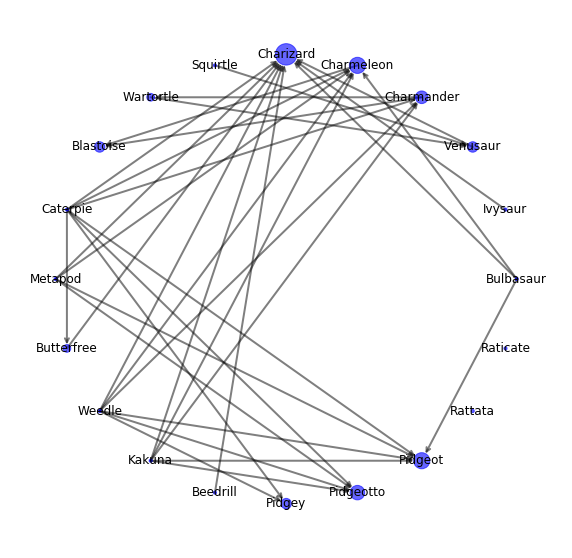

In [530]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue',alpha=0.6)
nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10,edge_cmap=plt.cm.Blues, width=2, alpha=0.5)
nx.draw_networkx_labels(G, pos)

plt.axis('off')
plt.show()

Much Sparser connection in this case.  Charizard asserts its dominance over the other starters in this subgraph, proving it to be the best starter.

In [475]:
#set diagonal to 0
np.fill_diagonal(pokemon_network, 0)

#normalize column 
P = np.zeros((n,n))
for k in range(n):
    if(sum(pokemon_network[:,k]) > 0):
        P[:,k] = pokemon_network[:,k]/sum(pokemon_network[:,k])
    
#uniform teleportation
v = np.ones(n)/n
alpha=0.9

delta = []

x = np.ones(n)/n
iters = 20
for i in range(iters):
    x_new = alpha*(P@x)+(1-alpha)*v
    x_new = x_new/sum(x_new)
    delta.append(np.linalg.norm(x-x_new))
    x = x_new

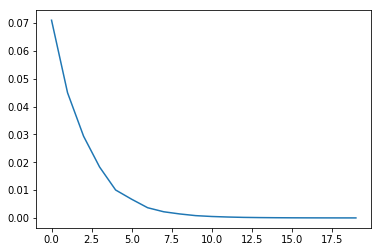

In [476]:
plt.plot(np.arange(iters), delta)

In [495]:
pokemons.iloc[x.argsort()[-10:]][["species","type1","type2"]]

,species,type1,type2
483,Palkia,water,dragon
382,Groudon,ground,None
486,Giratina,ghost,dragon
331,Cacturne,grass,dark
256,Blaziken,fire,fighting
148,Dragonite,dragon,flying
247,Tyranitar,rock,dark
372,Salamence,dragon,flying
482,Dialga,steel,dragon
383,Rayquaza,dragon,flying


In [502]:
a = np.ones(n)/n

iters = 30

A = pokemon_network
for i in range(iters):
    h = A.T@a
    h = h/sum(h)
    a = A@h
    a = a/sum(a)


In [503]:
pokemons.iloc[a.argsort()[-10:]][["species","type1","type2"]]

,species,type1,type2
425,Drifblim,ghost,flying
248,Lugia,psychic,flying
429,Honchkrow,dark,flying
5,Charizard,fire,flying
148,Dragonite,dragon,flying
372,Salamence,dragon,flying
383,Rayquaza,dragon,flying
145,Moltres,fire,flying
249,Ho-Oh,fire,flying
143,Articuno,ice,flying


Drifblim!?!?!

In [507]:
pokemons.iloc[h.argsort()[-10:]][["species","type1","type2"]]

,species,type1,type2
264,Wurmple,bug,None
9,Caterpie,bug,None
190,Sunkern,grass,None
290,Ninjask,bug,flying
13,Kakuna,bug,poison
68,Bellsprout,grass,poison
192,Yanma,bug,flying
166,Spinarak,bug,poison
414,Combee,bug,flying
12,Weedle,bug,poison


# New Conclusion

With the sparse network, the ranking becomes more interesting.  The list generated by pagerank is quite different from the nodes with the most edges pointing toward it, and the list generated by HITS is different from that of pagerank.  

1. Pagerank indicates that dragon types are heavily favoured in matchups, with the top list being mostly dragon and legendary.  This aligns with popular belief that dragon types are OP.
2. HITS's authorities consists of mainly flying types, with fewer entries of dragon types than pagerank.   In addition, it indicates that bug types are really bad.  In fact, it thinks that flying type is so good that Drifblim has really high authority, and deems bugs so bad that Ninjask is a top hub despite being a flying type.